## PurpleAir Data
Data are available via PurpleAir's API. You will need to use a gmail account and create an API key via [this dashboard](https://develop.purpleair.com/sign-in?redirectURL=%2Fdashboards%2Fkeys). You should create a "Read" key that has a status of "Enabled". It's a good idea to add a label, host restrictions restrict the use of the key to certain machines, you do not need to set these. 

TODO: insert screen shot image

Once you have generated your key, you can "read" the key value to use in making requests. First, run the cell below and enter the key you generated when prompted. 

If you do not have a Gmail account, or you don't want to set up an API, sample data shown here have been saved as part of the repository and can be used directly, just skip down to [insert section]

In [19]:
# imports
import glob
import datetime
import time
import pytz
import getpass
import requests


import geopandas as gpd
import pandas as pd


In [2]:

api_key = getpass.getpass("Enter your API key:")

Test your API key by running the code below. It should show the message "Key submit was successful" if your key is valid. 

In [3]:
url = "https://api.purpleair.com/v1/keys"

headers = {
    "X-API-Key": api_key 
}

response = requests.get(url, headers=headers)

if response.status_code == 201:
    print('Key submit was successful')
    data = response.json()
    print(data)
else:
    print(f"Request failed with status code: {response.status_code}")

Key submit was successful
{'api_version': 'V1.0.14-0.0.58', 'time_stamp': 1746496204, 'api_key_type': 'READ'}


If the API key is valid ("Key submit was successful"), a bounding box can be used to search for sensors. The coordinates in the cell below represent the longitude and latitude of the northwest and southeast corners of a box that encloses the South Bronx. The API request returns the identifiers of sensors within that bounding box. 

In [6]:
# corner latitude and longitudes in decimal degrees
nwlat = 40.9
nwlng = -73.933
selat = 40.80
selng = -73.78

url = 'https://api.purpleair.com/v1/sensors'

headers = {"X-API-Key": api_key}

params = {
    'fields':'name,latitude,longitude,position_rating,last_seen,date_created,private',
    'location_type':0,
    'nwlng':nwlng,
    'nwlat':nwlat,
    'selng':selng,
    'selat':selat

}

with requests.get(url, headers=headers, params=params) as response:

    if response.status_code == 200:
        print('Success')
        data = response.json()
        print(f'Request returned {len(data)} sensors')
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)


Success
Request returned 8 sensors


We can convert the sensor list to a dataframe and save it for future use. 

In [7]:
df = pd.DataFrame(data['data'], columns=data['fields'])
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude), 
    crs="EPSG:4326"
)

print(gdf.shape)
gdf.to_parquet('./SouthBronxSensors.parquet', engine='pyarrow', compression='snappy')


(9, 9)


If the data didn't download properly, or you cannot set up an API key, you can uncomment the code below will load the locally saved version of the file. 

In [14]:
gdf = gpd.read_parquet('./data/SouthBronxPurpleAirSensors.parquet')
print(gdf.shape)
gdf.head()


(10, 9)


sensor_index  date_created   last_seen  private         name  \
0         90249    1605560768  1744725955        0  FreshAir-O4   
1         90269    1605561082  1744725911        0        FA-O4   
2         90283    1605561111  1744716474        0     SIS-roof   
3         90389    1605561629  1744725226        0       FA-AHo   
4         91423    1605893083  1744726007        0       FA-O2b   

   position_rating   latitude  longitude                    geometry  
0                3  40.861225 -73.890160  POINT (-73.89016 40.86122)  
1                5  40.858074 -73.888980  POINT (-73.88898 40.85807)  
2                5  40.815360 -73.888374  POINT (-73.88837 40.81536)  
3                5  40.830220 -73.922340  POINT (-73.92234 40.83022)  
4                5  40.861134 -73.891556  POINT (-73.89156 40.86113)

In [9]:
## check if any of the sensors are private
print(len(gdf[gdf['private'] == 1]))
# map to show the sensors
#gdf.explore()


0


With several sensors available, data can be pulled from the API. First, we can look at the sensors date created and last date collected to see if they are likely to have data in the time period we are interested in. Pandas, a library for working with datatables, has a helper method to convert the timestamp in the data from seconds to a human-readable date and time. 

In [10]:
# date_created is when the sensor was set up in the database, last_seen
# is the date & time for the last sensor recording
print('Date Created:')
print(pd.to_datetime(gdf.date_created, unit='s'))
print('\nDate Last Seen:')
print(pd.to_datetime(gdf.last_seen, unit='s'))

Date Created:
0   2020-11-16 21:06:08
1   2020-11-16 21:11:22
2   2020-11-16 21:11:51
3   2020-11-16 21:20:29
4   2020-11-23 18:54:41
5   2020-11-24 17:25:14
6   2020-11-24 17:25:22
7   2022-11-29 19:05:50
8   2023-12-27 16:41:38
Name: date_created, dtype: datetime64[ns]

Date Last Seen:
0   2025-05-06 01:52:26
1   2025-05-06 01:52:29
2   2025-05-06 01:50:49
3   2025-05-06 01:51:56
4   2025-05-01 15:24:25
5   2025-05-06 01:52:22
6   2025-05-06 01:51:07
7   2025-05-06 01:52:37
8   2025-05-06 01:50:44
Name: last_seen, dtype: datetime64[ns]


From this, it can be seen that all of the sensors were created before the fires, and all have collected data recently. Next, the code below will retrieve data from one of the sensors for the date of the event. 

To retrieve data, the sensor ID is used to construct a new request, including the columns we want to include and the date/time range from which to get data. 

In [11]:
# TODO: turn comments into table above
fields = [
    'pm2.5_alt',        #Estimated mass concentration PM2.5 (µg/m³).
    'pm2.5_atm',        #Estimated mass concentration PM2.5 (µg/m³) (raw value).
    'humidity',         #Relative humidity inside of the sensor housing (%). This matches the "Raw Humidity" map layer and on average is 4% lower than ambient conditions.
    'temperature',      #Temperature inside of the sensor housing (F). This matches the "Raw Temperature" map layer and on average is 8°F higher than ambient conditions.
    'pressure',         #Current pressure in Millibars.
]

In [12]:
# start and end datetime stamps
# stored on the server in UTC, so we
# need to convert the timezone before
# making the timestamp
tz = pytz.timezone('America/New_York')

start_date = tz.localize(datetime.datetime(2024,11,7,0,0,0))
end_date = tz.localize(datetime.datetime(2024,11,10,23,59,59))

print(start_date)
print(end_date)
## convert to UTC time zone and generate timestamp
start_timestamp = start_date.astimezone(pytz.utc).timestamp()
end_timestamp = end_date.astimezone(pytz.utc).timestamp()


2024-11-07 00:00:00-05:00
2024-11-10 23:59:59-05:00


In [ ]:
def get_sensor_data(sensor_id,field_names,start_date_stamp,end_date_stamp):
    '''Construct request and fetch the sensor data '''

    # update the url, it is the API sensor url with :sensor after the end of the base URL
    url = f"https://api.purpleair.com/v1/sensors/{sensor_id}/history"     

    params = {
        'fields':",".join(fields),
        'start_timestamp':start_date_stamp,
        'end_timestamp':end_date_stamp,

    }
    time.sleep(2) # add a pause to avoid "too many requests" error (429)
    with requests.get(url=url, headers=headers, params=params) as response:

        if response.status_code == 200 or response.status_code == 201:
            print('Success')
            sensor_data = response.json()
            print(len(sensor_data))


        else:
            print(f"Request failed with status code: {response.status_code}")
            print(response.text)
            return None
        
        return sensor_data
    

In [34]:
sensor_response_data = dict()
sensor_ids = gdf.sensor_index.values
print(sensor_ids)
for id in sensor_ids:
    sensor_response_data[id] = get_sensor_data(
        id,
        field_names=fields,
        start_date_stamp=start_timestamp,
        end_date_stamp=end_timestamp
    )

[ 90249  90269  90283  90389  91899  92169  92171 172111 208355]
Success
9
Success
9
Success
9
Success
9
Success
9
Success
9
Success
9
Success
9
Success
9


In [33]:
# This code is only required if one of the requests fails! 
# locate failed request(s), which return None
keys = []
for key, value in sensor_response_data.items():
    if value is None:
        keys.append(key)

# update manually
for key in keys: 
    sensor_response_data[id] = get_sensor_data(
            id,
            field_names=fields,
            start_date_stamp=start_timestamp,
            end_date_stamp=end_timestamp
        )

In [18]:
## This code will save the files locally, maybe not required for the 
## course? Or could add a note "if you want to retain a local copy 
## of the data..."
import pickle
for key, value in sensor_response_data.items():
    with open(f'./data/raw_sensor_data_{key}.pickle', 'wb') as f:
        pickle.dump(value, f)

### Option: Load Data Manually
If you don't have an API key, or the data didn't download, the code below can be used to load the data from local files

In [ ]:
pickle_files = glob.glob("./data/raw_sensor_data*.pickle")
print(f'loading {len(pickle_files)} sensor files...')
sensor_response_data = dict()
for pfile in pickle_files:
    # pull the sensor id 
    sensor_id = pfile[pfile.rindex('_')+1:pfile.rindex('.')]
    with open(pfile, 'rb') as f:
        sensor_response_data[sensor_id] = pickle.load(f)

print(sensor_response_data)

loading 10 sensor files...
{'208355': {'api_version': 'V1.0.14-0.0.58', 'time_stamp': 1746538615, 'sensor_index': 208355, 'start_timestamp': 1730955600, 'end_timestamp': 1731301199, 'average': 10, 'private': 0, 'fields': ['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt', 'pm2.5_atm'], 'data': [[1731074400, 48.4, 58.2, 573.956, 2.7, 4.157], [1731102000, 29.0, 68.8, 580.084, 3.3, 5.069], [1731027000, 40.0, 64.0, 577.53, 2.1, 2.916], [1731105000, 30.0, 67.6, 579.446, 1.9, 2.45], [1731037200, 42.0, 61.0, 575.826, 15.4, 28.041], [1731028800, 40.6, 63.8, 577.096, 1.0, 0.953], [1731025800, 40.0, 64.4, 577.676, 10.9, 20.482], [1731030000, 41.6, 63.2, 577.072, 1.0, 0.933], [1731100200, 28.4, 69.0, 580.168, 1.9, 2.4939999999999998], [1731051000, 44.0, 59.8, 574.788, 105.7, 147.531], [1731026400, 40.0, 64.0, 577.626, 10.7, 18.994], [1731055200, 46.4, 58.8, 574.19, 1.5, 1.618], [1731064200, 54.0, 55.6, 572.462, 1.9, 2.589], [1731060600, 50.6, 57.0, 573.242, 1.9, 2.4139999999999997]

In [37]:
print(sensor_response_data)
    

{np.int64(90249): {'api_version': 'V1.0.14-0.0.58', 'time_stamp': 1746539818, 'sensor_index': 90249, 'start_timestamp': 1730955600, 'end_timestamp': 1731301199, 'average': 10, 'private': 0, 'fields': ['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt', 'pm2.5_atm'], 'data': [[1731287400, 51.8, 61.8, 1014.644, 6.4, 11.685], [1731291000, 64.2, 62.0, 1014.082, 3.7, 6.506], [1731298800, 93.0, 59.0, 1011.984, 4.1, 7.475], [1731298200, 90.2, 59.0, 1012.122, 3.7, 6.378], [1731289200, 58.4, 62.0, 1014.674, 5.6, 10.058], [1731296400, 84.0, 60.6, 1012.598, 3.7, 6.219], [1731294000, 73.4, 61.8, 1013.334, 4.0, 6.933], [1731289800, 61.4, 62.0, 1014.438, 5.3, 9.442], [1731293400, 72.2, 62.0, 1013.464, 4.7, 7.97], [1731285000, 44.4, 61.0, 1015.928, 5.5, 9.924], [1731284400, 43.0, 61.0, 1016.222, 5.0, 9.039], [1731288600, 55.8, 62.0, 1014.532, 6.1, 10.967], [1731295200, 79.2, 61.2, 1013.14, 3.3, 5.525], [1731283200, 42.6, 61.0, 1016.692, 4.5, 7.861], [1731299400, 95.8, 58.4, 1011.794, 4.

In [55]:
# function to create dataframe from retrieved data
#def dataframe_from_api_data(records:list, column_names:list, timestamp_column:str=None)->pd.DataFrame:
def dataframe_from_api_data(records, column_names, sensor_id = None, timestamp_column=None):
    '''create a pandas dataframe using the supplied list of records and list of column names,
    set the index to be the datetime stamp, and sort the dataframe'''
    new_df = pd.DataFrame(
        data=records,
        columns=column_names
    )
    # if the sensor id is supplied, add it as a column
    if sensor_id:
        new_df['sensor_id'] = sensor_id

    # if there is a timestamp column, convert it, set it as an index,
    # and then sort the dataframe
    if timestamp_column:
        tmp_col = 'date_time_stamp'
        new_df[tmp_col] =  pd.to_datetime(new_df[timestamp_column], unit='s')
        new_df.set_index(tmp_col, inplace=True)
        return new_df.sort_index()
    return new_df
    

In [53]:
sensor_response_data[90249].get('fields')

['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt', 'pm2.5_atm']

In [67]:
## create a dataframe to hold all of the sensor data using the fields from the
## first sensor 
#sensor_df = pd.DataFrame(columns=sensor_response_data.get(90249)['fields']+['sensor_id'])
# sensor_data = sensor_response_data.get(90249)
data_frames = []
for key, sensor_data in sensor_response_data.items(): 
        if len(sensor_data.get('data')) == 0:
                print(f'Skipping empty data file for {key}')
                continue # skip empty files
        data_frames.append(dataframe_from_api_data(
            records = sensor_data.get('data'),
            column_names = sensor_data.get('fields'),
            sensor_id=key,
            timestamp_column='time_stamp'
        )

    )
sensor_df = pd.concat(data_frames)
# have a look at the output
print(sensor_df.shape)
print(sensor_df['sensor_id'].unique())
sensor_df.head()

Skipping empty data file for 90283
(4187, 7)
[ 90249  90269  90389  91899  92169  92171 172111 208355]


time_stamp  humidity  temperature  pressure  pm2.5_alt  \
date_time_stamp                                                               
2024-11-07 05:00:00  1730955600      50.0         79.0  1014.706        2.9   
2024-11-07 05:10:00  1730956200      50.4         78.4  1014.772        3.0   
2024-11-07 05:20:00  1730956800      51.2         78.2  1014.652        2.9   
2024-11-07 05:30:00  1730957400      52.2         76.8  1013.732        2.8   
2024-11-07 05:40:00  1730958000      53.2         77.8  1014.646        2.6   

                     pm2.5_atm  sensor_id  
date_time_stamp                            
2024-11-07 05:00:00      4.749      90249  
2024-11-07 05:10:00      4.643      90249  
2024-11-07 05:20:00      4.743      90249  
2024-11-07 05:30:00      4.640      90249  
2024-11-07 05:40:00      4.167      90249

<Axes: xlabel='tmp_datetime'>

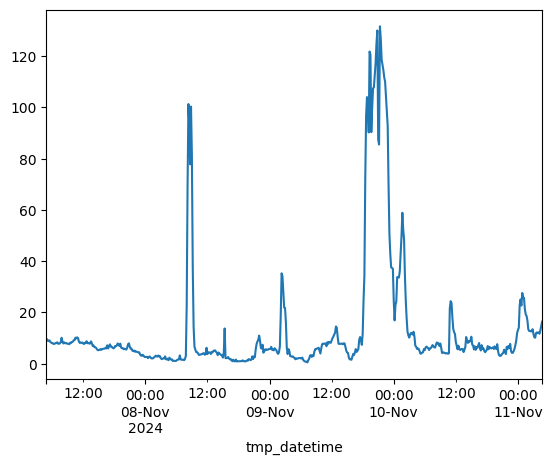

In [106]:
df_sensor['pm2.5_atm'].plot()


<Axes: >

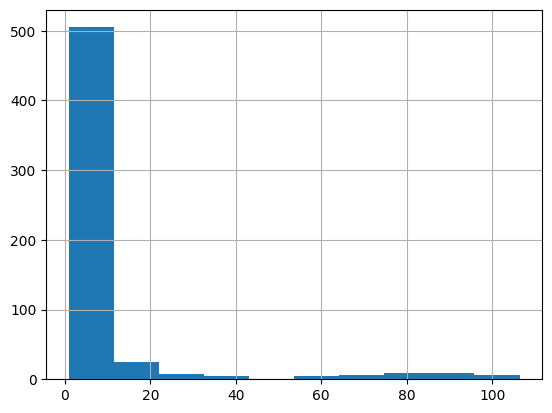

In [107]:

df_sensor['pm2.5_alt'].hist()



<Axes: xlabel='tmp_datetime'>

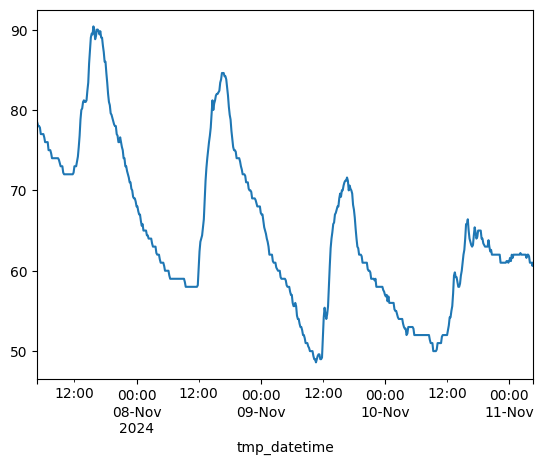

In [108]:
df_sensor['temperature'].plot()

<Axes: xlabel='tmp_datetime'>

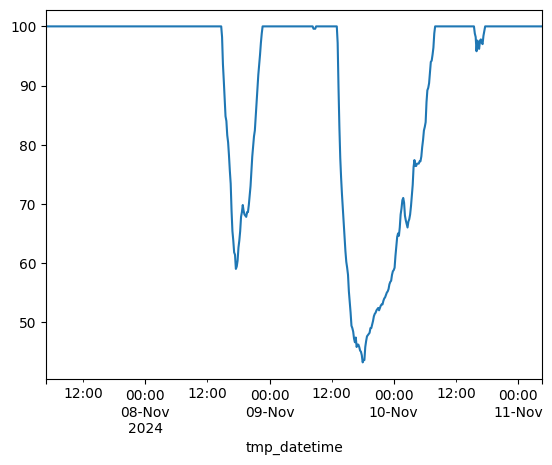

In [109]:
df_sensor['humidity'].plot()

<Axes: xlabel='tmp_datetime'>

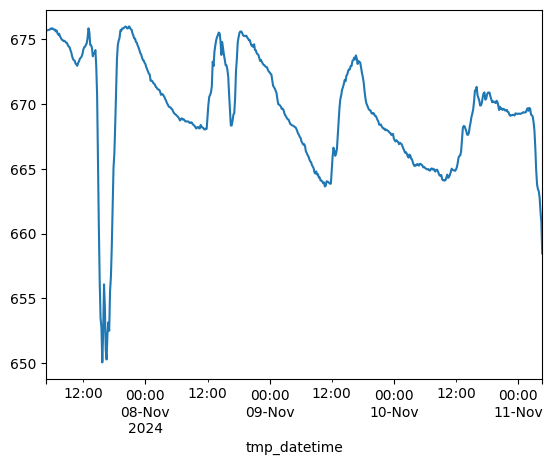

In [110]:
df_sensor['pressure'].plot()

In [111]:
# write out the data so we don't have to fetch it again
out_file = f'PurpleAir_sensor_{id}_2024_11_07_to_11_10.parquet'
df_sensor.to_parquet(f'./data/{out_file}')

In [82]:
#start_date = datetime.datetime(2024,11,7).timestamp()
#end_date = datetime.datetime(2024,11,10).timestamp()
datetime.datetime(2024,11,10,23,59,59).timestamp()


1731301199.0

In [112]:
df_sensor.index.min()

Timestamp('2024-11-07 04:50:00')

In [113]:
df_sensor.index.max()

Timestamp('2024-11-11 04:40:00')

In [3]:
df_sensor = pd.read_parquet('./data/PurpleAir_sensor_90269_2024_11_07_to_11_10.parquet')

In [5]:
df_sensor.head()

time_stamp  humidity  temperature  pressure  pm2.5_alt  \
tmp_datetime                                                                  
2024-11-07 04:50:00  1730955000     100.0         78.4   675.670        5.8   
2024-11-07 05:00:00  1730955600     100.0         78.0   675.678        5.7   
2024-11-07 05:10:00  1730956200     100.0         78.0   675.702        5.5   
2024-11-07 05:20:00  1730956800     100.0         77.8   675.716        5.5   
2024-11-07 05:30:00  1730957400     100.0         77.0   675.732        5.5   

                     pm2.5_atm  
tmp_datetime                    
2024-11-07 04:50:00      9.734  
2024-11-07 05:00:00      9.562  
2024-11-07 05:10:00      8.864  
2024-11-07 05:20:00      8.999  
2024-11-07 05:30:00      9.073

<Axes: xlabel='tmp_datetime'>

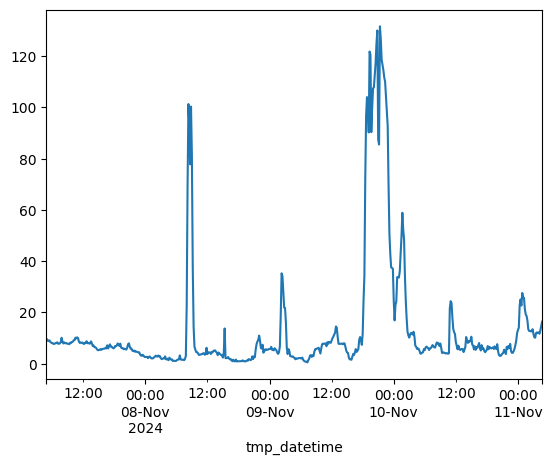

In [7]:
df_sensor['pm2.5_atm'].plot()

<Axes: xlabel='tmp_datetime'>

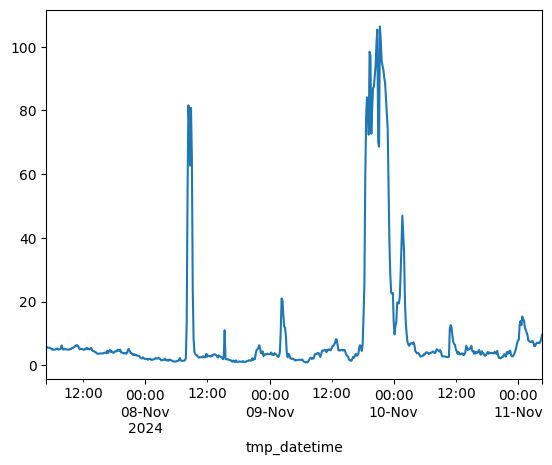

In [9]:
df_sensor['pm2.5_alt'].plot()